**导入需要的模块**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

**读取数据**

In [2]:
data = pd.read_csv('../input/train.csv',index_col=0)

**查看数据情况**

In [3]:
data.shape

(1460, 80)

In [4]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**查看数据特征类型, 即除SalePrice的列，有数值类型(numerical)和类别类型（category）**

统计数值类型(numerical)特征名，保存为列表

In [5]:
numerical = [f for f in data.drop('SalePrice',axis=1).columns if data.drop('SalePrice',axis=1).dtypes[f] != 'object']

In [6]:
print('数值类型数量：{}'.format(len(numerical)))

数值类型数量：36


统计类别类型（category）特征名，保存为列表

In [7]:
category = [f for f in data.drop('SalePrice',axis=1).columns if data.drop('SalePrice',axis=1).dtypes[f] == 'object']

In [8]:
print('类别类型数量：{}'.format(len(category)))

类别类型数量：43


**缺失值处理**

缺失值列名确定

In [9]:
missing = data.isnull().sum()

In [10]:
missing = missing[missing>0].sort_values(ascending=False)

In [11]:
missing.tail()

BsmtCond      37
BsmtQual      37
MasVnrArea     8
MasVnrType     8
Electrical     1
dtype: int64

保存缺失值的特征的类型

In [12]:
types = data[missing.index].dtypes

计算缺失占比

In [13]:
percent = missing / len(data)

In [14]:
missing_data = pd.concat([missing,types,percent],axis=1,keys=['Total','Types','Percent'])

In [15]:
missing_data[missing_data['Percent']<=0.15]

,Total,Types,Percent
GarageType,81,object,0.055479
GarageYrBlt,81,float64,0.055479
GarageFinish,81,object,0.055479
GarageQual,81,object,0.055479
GarageCond,81,object,0.055479
BsmtExposure,38,object,0.026027
BsmtFinType2,38,object,0.026027
BsmtFinType1,37,object,0.025342
BsmtCond,37,object,0.025342
BsmtQual,37,object,0.025342


对缺失值超过15%的特征进行删除

In [16]:
data.drop(missing_data[missing_data['Percent']>0.15].index,axis=1,inplace=True)

In [17]:
data.shape

(1460, 74)

少部分缺少的类别数据用众数填充

In [18]:
data['Electrical'].fillna(data['Electrical'].mode()[0], inplace=True)

对应的的空值表示没有该项设施，则空值可以用‘None’填充,即将空值视为新的类别

In [19]:
missing_data[(missing_data['Percent'] <= 0.15) & (missing_data['Types'] == 'object')].index

Index(['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrType', 'Electrical'],
      dtype='object')

In [20]:
none_col = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrType']
for i in none_col:
    data[i].fillna('None',inplace=True)

MasVnrArea表示砖石贴面面积，如果一个房子本身没有砖石贴面，则缺失值就用0来填补

In [21]:
data['MasVnrArea'].fillna(0,inplace=True)

对车库建造以每20年为一个分段，将年份离散化

In [22]:
year_map = pd.concat(pd.Series('YearGroup' + str(i+1), 
           index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

In [23]:
data['GarageYrBlt'] = data['GarageYrBlt'].map(year_map)

In [24]:
data['GarageYrBlt']= data['GarageYrBlt'].fillna('None')

再次查询缺失值

In [25]:
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

**对SalePrice进行分析**

描述性分析

In [26]:
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

概率密度图

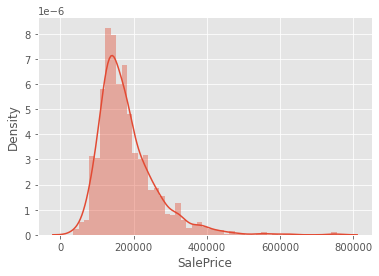

In [27]:
sns.distplot(data['SalePrice'])
plt.show()

偏度skewness and 峰度kurtosis计算

In [28]:
print('偏度：%f'%data['SalePrice'].skew())
print('峰度：%f'%data['SalePrice'].kurt())

偏度：1.882876
峰度：6.536282


采用ln（x+1）进行转化

In [29]:
data['SalePrice'] = np.log1p(data['SalePrice'])

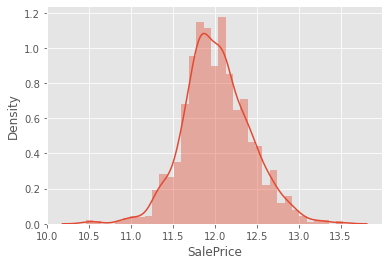

In [30]:
sns.distplot(data['SalePrice'])
plt.show()

偏度skewness and 峰度kurtosis再计算

In [31]:
print('偏度：%f'%data['SalePrice'].skew())
print('峰度：%f'%data['SalePrice'].kurt())

偏度：0.121347
峰度：0.809519


删除基于SalePrice3倍标准差的异常值

In [32]:
data = data[np.abs(data['SalePrice'] - data['SalePrice'].mean())-(3*data['SalePrice'].std())<=0]

In [33]:
print('偏度：%f'%data['SalePrice'].skew())
print('峰度：%f'%data['SalePrice'].kurt())

偏度：0.151557
峰度：0.091839


画qq图，该图斜率表示标准差，截距为均值，查看SalePrice是否服从正态分布

越接近直线，越显正态性

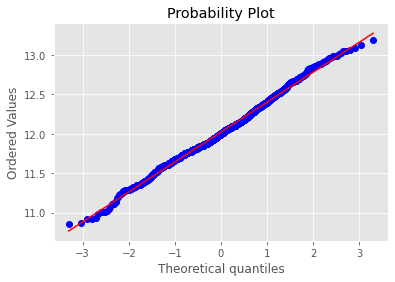

In [34]:
res = stats.probplot(data['SalePrice'],plot=plt)

In [35]:
data.shape

(1448, 74)

**相关性分析**

In [36]:
corrmat = data.corr()

In [37]:
# 计算与房价相关性大于0.5的特征个数
k = len(corrmat[corrmat['SalePrice'] > 0.5].index)
k

11

In [38]:
# 获取前k个重要的特征名
corr_col = corrmat.nlargest(k,'SalePrice')['SalePrice'].index.tolist()

In [39]:
corrmat_k = data[corr_col].corr()

可视化热图

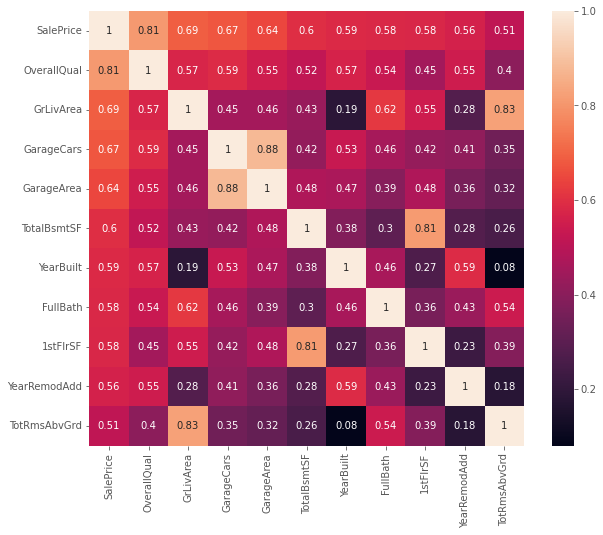

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(corrmat_k,annot=True,square=True)
plt.show()

对面积特征画多变量图

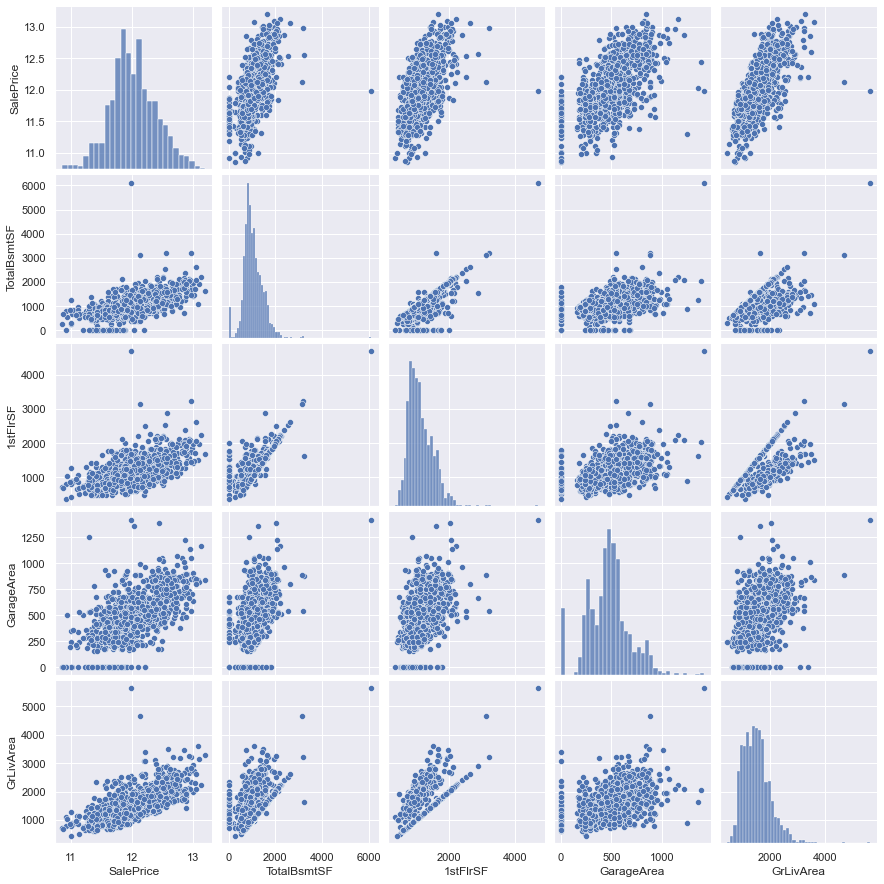

In [41]:
sns.set()
area = ['SalePrice','TotalBsmtSF','1stFlrSF','GarageArea','GrLivArea']
sns.pairplot(data[area],size=2.5)
plt.show()

In [42]:
# 由上图第一行后三个图可知基于'TotalBsmtSF','1stFlrSF', 'GrLivArea','GarageArea'
# 特征分别存在1、1、4、2个异常值，可剔除掉
data.drop(data[data['TotalBsmtSF'] > 4000].index, inplace=True)
data.drop(data[data['1stFlrSF'] > 4000].index, inplace=True)
data.drop(data[data['GrLivArea'] > 4000].index, inplace=True)
data.drop(data[data['GarageArea'] > 1240].index, inplace=True)

In [43]:
data.shape

(1443, 74)

In [44]:
# 分别计算'TotalBsmtSF','1stFlrSF', 'GrLivArea'，
#‘GarageArea'偏度skewness and 峰度kurtosis计算
print("TotalBsmtSF偏度: %f" % data['TotalBsmtSF'].skew())
print("TotalBsmtSF峰度: %f" % data['TotalBsmtSF'].kurt())
print("1stFlrSF偏度: %f" % data['1stFlrSF'].skew())
print("1stFlrSF峰度: %f" % data['1stFlrSF'].kurt())
print("GrLivArea偏度: %f" % data['GrLivArea'].skew())
print("GrLivArea峰度: %f" % data['GrLivArea'].kurt())
print("GarageArea偏度: %f" % data['GarageArea'].skew())
print("GarageArea峰度: %f" % data['GarageArea'].kurt())

TotalBsmtSF偏度: 0.414384
TotalBsmtSF峰度: 1.539572
1stFlrSF偏度: 0.867507
1stFlrSF峰度: 1.100841
GrLivArea偏度: 0.820895
GrLivArea峰度: 0.901041
GarageArea偏度: 0.022238
GarageArea峰度: 0.448625


In [45]:
# 将偏度大于0.75的'1stFlrSF', 'GrLivArea'进行ln(x + 1)
#转化生成新特征‘ln_1stFlrSF’和‘ln_GrLivArea’
data['ln_1stFlrSF'] = np.log1p(data["1stFlrSF"])
data['ln_GrLivArea'] = np.log1p(data["GrLivArea"])
print("ln_1stFlrSF偏度: %f" % data['ln_1stFlrSF'].skew())
print("ln_1stFlrSF峰度: %f" % data['ln_1stFlrSF'].kurt())
print("ln_GrLivArea偏度: %f" % data['ln_GrLivArea'].skew())
print("ln_GrLivArea峰度: %f" % data['ln_GrLivArea'].kurt())

ln_1stFlrSF偏度: 0.022909
ln_1stFlrSF峰度: -0.200772
ln_GrLivArea偏度: -0.059680
ln_GrLivArea峰度: -0.241430


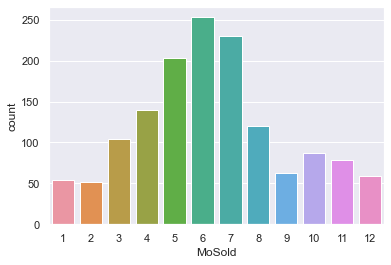

In [46]:
# 查看非线性特征，不同月份的房子的销售量
# 画出直方图，查看呈现规律
sns.countplot(x='MoSold',data=data)
plt.show()

In [47]:
# 查看数据特征类型, 即除SalePrice的列，有数值类型(numerical)和类别类型（category）
numeric = [f for f in data.drop(['SalePrice'], axis=1).columns 
           if data.drop(['SalePrice'], axis=1).dtypes[f] != 'object']
category = [f for f in data.drop(['SalePrice'], axis=1).columns 
            if data.drop(['SalePrice'], axis=1).dtypes[f] == 'object']
# 输出数值类型(numerical)特征个数，类型（category）特征个数
print("numeric: {}, category: {}" .format (len(numeric),len(category)))

numeric: 36, category: 39


In [48]:
# 对类别型数据做方差分析
# 定义方差函数，返回p-value值，其值越小对应特征越重要
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = category
    pvals = []
    for c in category:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        # stats.f_onewaym模块包由于计算p-value
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    # 将特征根据p-valu排序
    return anv.sort_values('pval')

# 将data带入定义的方差函数
a = anova(data)
# 输出a
a

,feature,pval
7,Neighborhood,2.348768e-237
17,ExterQual,8.553538e-194
29,KitchenQual,2.905300e-184
20,BsmtQual,6.686655e-184
33,GarageFinish,9.518461e-150
32,GarageYrBlt,1.216344e-143
31,GarageType,4.516320e-122
19,Foundation,1.642325e-109
26,HeatingQC,5.024923e-79
23,BsmtFinType1,4.325070e-76


In [54]:
# 重要数值型特征数据整合
# 用新的 df 构建数据集
# 选择相关性大于0.5的重要数值型特征
df = data[corr_col]
# 将 1stFlrSF 和 GrLivArea 特征ln(x+1)转化
df["1stFlrSF"] = data['ln_1stFlrSF']
df["GrLivArea"] = data['ln_GrLivArea']
# 将时间特征离散化，即没20年分段
df['YearBuilt'] = df['YearBuilt'].map(year_map)
df['YearRemodAdd'] = df['YearRemodAdd'].map(year_map)
# 对非线性特征 MoSold one-hot编码
month = pd.get_dummies(data['MoSold'],prefix='MoSold')
# 合并特征
df = pd.concat([df, month], axis=1)

In [55]:
df.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,YearBuilt,FullBath,1stFlrSF,YearRemodAdd,...,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12
Id,,,,,,,,,,,,,,,,,,,,,
1,12.247699,7,7.444833,2,548,856,YearGroup7,2,6.753438,YearGroup7,...,0,0,0,0,0,0,0,0,0,0
2,12.109016,6,7.141245,2,460,1262,YearGroup6,2,7.141245,YearGroup6,...,0,0,1,0,0,0,0,0,0,0
3,12.317171,7,7.488294,2,608,920,YearGroup7,2,6.825460,YearGroup7,...,0,0,0,0,0,0,1,0,0,0
4,11.849405,7,7.448916,3,642,756,YearGroup3,1,6.869014,YearGroup5,...,0,0,0,0,0,0,0,0,0,0
5,12.429220,8,7.695758,3,836,1145,YearGroup7,2,7.044033,YearGroup7,...,0,0,0,0,0,0,0,0,0,1


In [56]:
# 对于类别型数据，跟据方差分析，选取排名重要的25个特征
features = a['feature'].tolist()[0:25]
# 合并特征
df = pd.concat([df, data[features]], axis=1)

In [57]:
df.shape

(1443, 48)

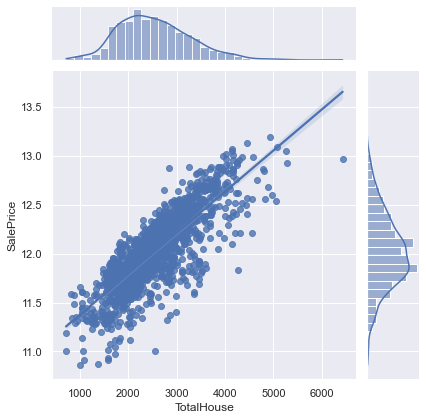

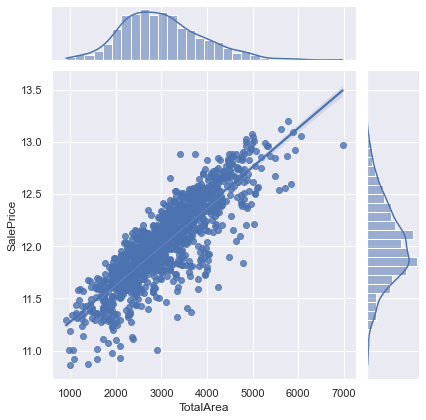

In [58]:
# 特征融合
# 将面积特征相加，构建总面积特征
df["TotalHouse"] = data["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"]
df["TotalArea"]=data["TotalBsmtSF"]+data["1stFlrSF"]+data["2ndFlrSF"]+data["GarageArea"]
# 画出其回归图
sns.jointplot(x=df["TotalHouse"], y=df['SalePrice'], data = df, kind="reg")
sns.jointplot(x=df["TotalArea"], y=df['SalePrice'], data = df, kind="reg")
plt.show()

In [59]:
# 由图可知融合的特征较好，TotalHouse、TotalArea分别含有1个异常,可将其剔除掉
df.drop(df[df['TotalHouse'] > 6000].index, inplace=True)
df.drop(df[df['TotalArea'] > 6500].index, inplace=True)

In [63]:
# 继续融合特征
# 将部分相关联的特征进行相加或相乘
df["+_TotalHouse_OverallQual"] = df["TotalHouse"] * data["OverallQual"]
df["+_GrLivArea_OverallQual"] = data["GrLivArea"] * data["OverallQual"]
df["+_BsmtFinSF1_OverallQual"] = data["BsmtFinSF1"] * data["OverallQual"]
df["-_LotArea_OverallQual"] = data["LotArea"] * data["OverallQual"]
df["-_TotalHouse_LotArea"] = df["TotalHouse"] + data["LotArea"]
df["Bsmt"] = data["BsmtFinSF1"] + data["BsmtFinSF2"] + data["BsmtUnfSF"]
df["Rooms"] = data["FullBath"]+data["TotRmsAbvGrd"] 
df["PorchArea"] = data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"]
df["TotalPlace"] = (df["TotalBsmtSF"] + data["1stFlrSF"] + data["2ndFlrSF"] + data["GarageArea"] 
                    + data["OpenPorchSF"] + data["EnclosedPorch"]+ data["3SsnPorch"] + data["ScreenPorch"])

In [65]:
# 将所有的类别型特征，one-hot编码
df = pd.get_dummies(df)
# 查看数据维度
df.shape

(1442, 216)

In [71]:
# 构建模型
# 导入GBDT算法
from sklearn.ensemble import GradientBoostingRegressor
# 导入均方误差计算
from sklearn.metrics import mean_squared_error
# 导入标准化模块包
from sklearn.preprocessing import RobustScaler
# 导入划分数据集包，交叉验证包
from sklearn.model_selection import train_test_split,KFold,cross_val_score
# 导入Xgboost算法包
import xgboost as xgb

In [72]:
# 特征标准化
x = RobustScaler().fit_transform(df.drop(['SalePrice'], axis=1).values)
# 提取标签
y = df['SalePrice'].values

In [73]:
def rmse_cv(model):
    # 将数据集shuffle打乱，划分成五分
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    # 计算均方根误差，其输出结果有五个
    rmse= np.sqrt(-cross_val_score(model,x,y,scoring="neg_mean_squared_error",cv = kf))
    return rmse

In [74]:
# GBDT算法
# 使用GBDT算法，构建模型
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.005,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score1 = rmse_cv(GBoost)
# 输出五个均方根误差的平均值RSME和其标准差SD,保留4位小数
print("Gradient Boosting score: RSME={:.4f} (SD={:.4f})\n".format(score1.mean(),score1.std()))

Gradient Boosting score: RSME=0.1130 (SD=0.0113)



In [75]:
# Xgboost算法
# Xgboost算法,构建模型
Xgboost = xgb.XGBRegressor(colsample_bytree=0.36, gamma=0.042, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.88, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state = 1, nthread = -1)
score2 = rmse_cv(Xgboost)
# 输出五个均方根误差的平均值RSME和其标准差SD,保留4位小数
print("Xgboost score: RSME={:.4f} (SD={:.4f})\n".format(score2.mean(),score2.std()))

[23:52:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:52:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:52:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

In [76]:
# 将80%数据作为训练集，20%数据作为测试集
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
# 定义回归拟合图,以预测值输入
def drawing(y_hat):
    # 获取预测的测试集从小到大排序的索引
    order = np.argsort(y_hat)
    # 将测试集和预测的测试集按索引排序
    y_test_new = y_test[order]
    y_hat = y_hat[order]
    # 画图展示
    plt.figure(figsize=(8, 6),facecolor='w')
    t = np.arange(len(y_test))
    plt.plot(t, y_test_new, 'b-', linewidth=2, label='True')
    plt.plot(t, y_hat, 'r-', linewidth=2, label='Predicted')
    plt.legend(loc='upper left')
    plt.grid(b=True)
    plt.show()

RMSE =  0.0984
R2_train = 0.9492
R2_test = 0.9274


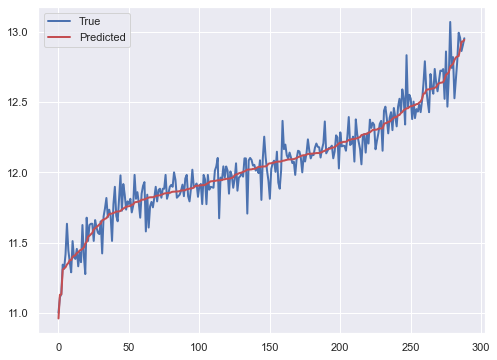

In [77]:
# 使用GBDT算法，构建模型
# 训练集训练
GBoost.fit(x_train, y_train)
# 测试集结果预测
y_hat1 = GBoost.predict(x_test)
# 分别输出均方根误差RMSE，训练集和测试集的拟合优度R2
print("RMSE =  %.4f" % np.sqrt(np.mean((y_hat1 - y_test) ** 2)))
print('R2_train = %.4f' % GBoost.score(x_train, y_train))
print('R2_test = %.4f' % GBoost.score(x_test, y_test))
# 画出拟合效果图，蓝色表示真实值，红色为预测值
drawing(y_hat1)

[23:53:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE =  0.1051
R2_train = 0.9492
R2_test = 0.9274


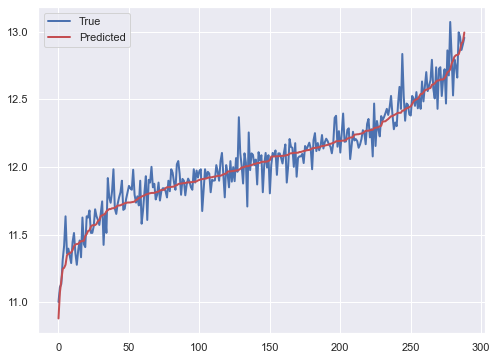

In [78]:
# 使用Xgboost算法，构建模型
# 训练集训练
Xgboost.fit(x_train, y_train)
# 测试集结果预测
y_hat2 = Xgboost.predict(x_test)
# 分别输出均方根误差RMSE，训练集和测试集的拟合优度R2
print("RMSE =  %.4f" % np.sqrt(np.mean((y_hat2 - y_test) ** 2)))
print('R2_train = %.4f' % GBoost.score(x_train, y_train))
print('R2_test = %.4f' % GBoost.score(x_test, y_test))
# 画出拟合效果图 ，蓝色表示真实值，红色为预测值
drawing(y_hat2)